## Application: Wave Damage To Cargo Ships
---

#### Variables:

+ type - type: "A" to "E".
+ year - year of construction: 1960–64, 65–69, 70–74, 75–79 (coded as "60", "65", "70", "75").
+ period - period of operation : 1960–74, 75–79.
+ service - aggregate months of service.
+ incidents - number of damage incidents.

#### Source:

ships - Ships Damage Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

McCullagh, P. and J. A. Nelder (1983) *Generalized Linear Models*, Second Edition, Chapman & Hall, Table 6.2, Page 205.


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display
# workaround for Theano compilation errors
import theano
theano.config.gcc.cxxflags = '-Wno-c++11-narrowing'

We consider the Poisson regression model:

\begin{align*}
 & \log(\text{expected number of damage incidents}) \\
 & = \beta_0 + \beta_1\log(\text{service}) + \beta_2(\text{ship type is B}) + \beta_3(\text{ship type is C}) + \beta_4(\text{ship type is D})+ \beta_5(\text{ship type is E}) \\
 & \quad + \beta_6(\text{year of construction: 1965-69}) + \beta_7(\text{year of construction: 1970-74})
    + \beta_8(\text{year of construction: 1975-79}) \\
 & \quad + \beta_9(\text{year of operation: 1975-79}).
\end{align*}


In [2]:
data = pd.read_csv('ships.csv', index_col=0)

We exclude the observations with `service` = 0.

In [3]:
data = data[data['service'] > 0]
log_service = np.log(data['service'].values).reshape((data.shape[0], 1))

Here we create dummy variables for ship types. The dummy variable for "A" is excluded.

In [4]:
str_type = data['type'].unique()
dummy_type = np.zeros((data.shape[0], str_type.size - 1))
for idx, ship_type in enumerate(str_type[1:]):
    dummy_type[:, idx] = (data['type'] == ship_type).values

Then we create dummy variables for years of construction. The dummy variable for 1960-64 is excluded.

In [5]:
str_year = data['year'].unique()
dummy_year =  np.zeros((data.shape[0], str_year.size - 1))
for idx, construction_year in enumerate(str_year[1:]):
    dummy_year[:, idx] = (data['year'] == construction_year).values

We create the dummy variable for period of operation.

In [6]:
str_period = data['period'].unique()
dummy_period =  np.zeros((data.shape[0], str_period.size - 1))
for idx, operation_period in enumerate(str_period[1:]):
    dummy_period[:, idx] = (data['period'] == operation_period).values

Finally we create the matrix of the independent variables `X` and the vector of the dependent variable `y`.

In [7]:
X = np.hstack((np.ones((data.shape[0],1)), log_service, dummy_type, dummy_year, dummy_period))
y = data['incidents'].values
var_names = ['constant', 'log_service', 'B', 'C', 'D', 'E', '65-69', '70-74', '75-79', 'operation']

In [8]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
poisson_regression_model = pm.Model()
with poisson_regression_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Poisson('y', mu=pm.math.exp(idx), observed=y)

In [9]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with poisson_regression_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123,
                      nuts_kwargs=dict(target_accept=0.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:42<00:00, 560.74draws/s]


In [10]:
post_stats = pm.summary(trace)
post_stats.index = var_names
display(post_stats)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
constant,-5.646,0.885,-7.332,-4.010,0.012,0.009,5358.0,5354.0,5369.0,8691.0,1.0
log_service,0.907,0.103,0.716,1.104,0.001,0.001,5592.0,5590.0,5601.0,8843.0,1.0
B,-0.348,0.274,-0.860,0.171,0.003,0.002,7769.0,7769.0,7773.0,10800.0,1.0
C,-0.795,0.346,-1.456,-0.155,0.003,0.002,14062.0,13582.0,14072.0,13993.0,1.0
D,-0.158,0.302,-0.730,0.402,0.003,0.002,12650.0,11432.0,12674.0,12827.0,1.0
E,0.268,0.244,-0.188,0.729,0.002,0.002,13250.0,12314.0,13251.0,13869.0,1.0
65-69,0.670,0.153,0.375,0.952,0.002,0.001,9312.0,9231.0,9316.0,12488.0,1.0
70-74,0.769,0.178,0.432,1.098,0.002,0.001,8063.0,8008.0,8071.0,11447.0,1.0
75-79,0.372,0.246,-0.103,0.818,0.003,0.002,8600.0,8600.0,8601.0,12370.0,1.0
operation,0.368,0.119,0.148,0.597,0.001,0.001,14619.0,14290.0,14604.0,13771.0,1.0


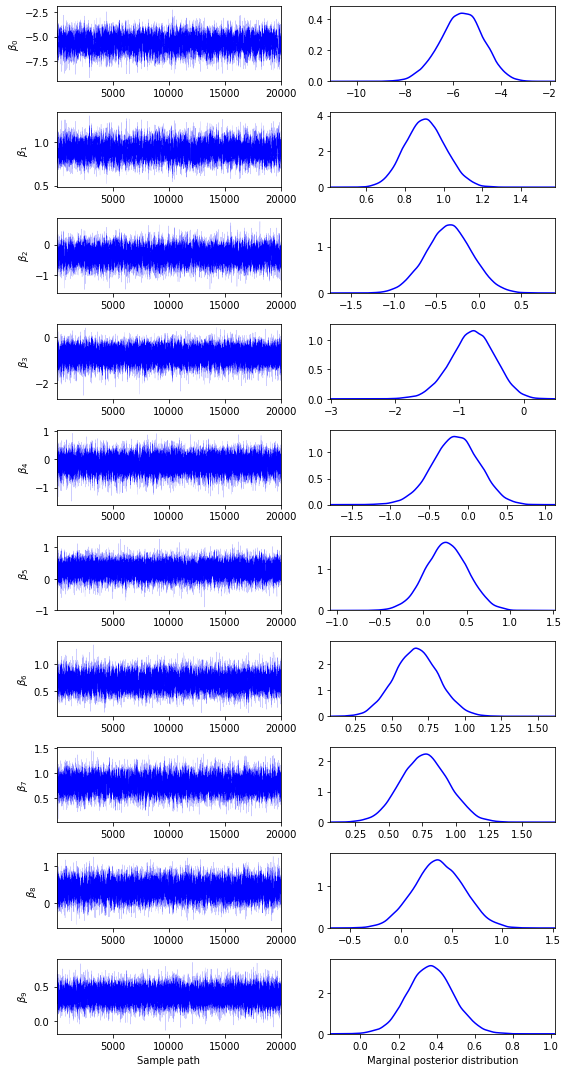

In [11]:
fig, ax = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for index in range(k):
    mc_trace = trace['b'][:, index]
    x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
    x_max =  mc_trace.max() + 0.2 * np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 0].plot(mc_trace, 'b-', linewidth=0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel('$\\beta_{:d}$'.format(index))
    ax[index, 1].plot(x, posterior, 'b-')
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
ax[k-1, 0].set_xlabel('Sample path')
ax[k-1, 1].set_xlabel('Marginal posterior distribution')
plt.tight_layout()
# plt.savefig('ms_fig_ships.png', dpi=300)
plt.show()